# Black Scholes Model

Some code snippets to solve the problem classically

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
import math
from math import exp, sqrt, acos

from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

from qiskit_finance.circuit.library.payoff_functions import EuropeanCallPricingObjective
from qiskit_finance.circuit.library.probability_distributions import LogNormalDistribution
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem

from qiskit.circuit.library import StatePreparation, RYGate


## Definition and variables

The Black-Scholes model is a mathematical model for the dynamics of a financial market containing derivative investment instruments. From the Black-Scholes equation, one can deduce the Black-Scholes formula, which gives a theoretical estimate of the price of European-style options. This formula relies on several key assumptions and uses the following variables defined in our notebook:

*   `S0`: The current stock price (initial stock price).
*   `K`: The strike price of the option.
*   `r`: The risk-free interest rate (annualized).
*   `sigma`: The volatility of the stock's returns (annualized standard deviation).
*   `T`: The time to expiration of the option (in years).

In [102]:
S0 = 1
K = 1
r = 0.02
sigma = 0.2
T = 5
n_steps = 5 #5
n_quantum_steps = 5
n_sim = 10000

## Simulations


The price of a put and a call can be calculated using an analytical formula with the Black-Scholes model. The value of $S_0$ is the initial value of the asset price, the value of $K$ is the strike price. The value of $r$ is the risk-free interest rate and the value $\sigma$ is the volatility of the stock price. The maturity of the option in years is $T$. The price of a put and a call option can be approximated using stochastic simulations using the following formula:

## Put Option

$$\text{Put} = e^{-rT}E\left[\max(K - S_T, 0)\right] = e^{-rT} \frac{1}{M} \sum_{i=1}^{M} \max(K - S_T^{(i)}, 0)$$

## Call Option

$$\text{Call} = e^{-rT}E\left[\max(S_T - K, 0)\right] = e^{-rT} \frac{1}{M} \sum_{i=1}^{M} \max(S_T^{(i)} - K, 0)$$

where $S_T^{(i)}$ is the simulated price of the simulation $i$ and $M$ is the number of simulations.

We can simulate the value of $S_T^{(i)}$ using the following algorithm:

1. **Step 1:** generate a random number from a standard normal distribution $W^{(i)}$;

2. **Step 2:** calculate $S_T^{(i)} = \exp\left((r - 0.5\sigma^2)T + \sqrt{T}\sigma W^{(i)}\right)$;

3. **Step 3:** repeat the first and second steps $M$ times;

4. **Step 4:** approximate the value of the put price using

   $$e^{-rT} \frac{1}{M} \sum_{i=1}^{M} \max(K - S_T^{(i)}, 0)$$

   or the value of the call price using

   $$e^{-rT} \frac{1}{M} \sum_{i=1}^{M} \max(S_T^{(i)} - K, 0).$$

The values of $\sqrt{T}W^{(i)}$ can be approximated using a random walk. Also, a high value of $M$ will generate better approximations of the put and call values.

In [77]:
def black_Scholes_Put_Simulation(S0, K, r,  sigma, T, n_sim):
    mean = (r - 0.5 * sigma ** 2) * T
    std = sigma * np.sqrt(T)
    rng = np.random
    z = rng.normal(loc = mean, scale = std, size = n_sim)
    ST = S0 * np.exp(z)
    payoff = np.maximum(K - ST, 0.0)
    price = np.exp(-r * T) * payoff.mean()
    return float(price)

def black_Scholes_Call_Simulation(S0, K, r, sigma, T, n_sim):
    mean = (r - 0.5 * sigma ** 2) * T
    std = sigma * np.sqrt(T)
    rng = np.random
    z = rng.normal(loc = mean, scale = std, size = n_sim)
    ST = S0 * np.exp(z)
    payoff = np.maximum(ST - K, 0.0)
    price = np.exp(-r * T) * payoff.mean()
    return float(price)

In [78]:
put_simulation = black_Scholes_Put_Simulation(S0, K, r,  sigma, T, n_sim)
call_simulation = black_Scholes_Call_Simulation(S0, K, r,  sigma, T, n_sim)
print(f"Put Simulation = {put_simulation}")
print(f"Call Simulation = {call_simulation}")

Put Simulation = 0.1268653844146722
Call Simulation = 0.22636915982399272


## Binomial Tree

In [79]:
def black_scholes_call_binomial_tree(S0, K, r, sigma, T, n_steps):
    delta_t = T / n_steps
    u = np.exp(np.sqrt(delta_t) * sigma)
    d = np.exp(-np.sqrt(delta_t) * sigma)
    p = (np.exp(delta_t * r) - d) / (u - d)

    n_rows = 2 * n_steps + 1
    n_rows_mid = (n_rows + 1) // 2
    tree = np.zeros((n_rows, n_steps + 1))
    tree[n_rows_mid - 1, 0] = S0

    for i in range(1, n_steps + 1):
        old_idx_non_zero = np.where(tree[:, i - 1] != 0)[0]
        new_idx_non_zero = np.unique(np.concatenate((old_idx_non_zero + 1, old_idx_non_zero - 1)))
        new_idx_non_zero = new_idx_non_zero[(new_idx_non_zero >= 0) & (new_idx_non_zero < n_rows)]
        new_S_val = np.unique(S0 * (u ** (new_idx_non_zero - (n_rows_mid - 1))))
        tree[new_idx_non_zero, i] = new_S_val

    x = np.arange(0, n_steps + 1)
    vec_prob_payoff = np.array([math.comb(n_steps, k) * (1 - p) ** k * p ** (n_steps - k) for k in x])
    bool_payoff = np.array([True if i % 2 == 0 else False for i in range(2 * n_steps)])
    bool_payoff = np.append(bool_payoff, True)

    vec_payoff = np.maximum(tree[bool_payoff, n_steps] - K, 0)
    call_price_binomial_tree = np.exp(-T * r) * np.sum(vec_payoff * vec_prob_payoff)

    return {
        "mat_Binomial_Tree": tree,
        "vec_Payoff": vec_payoff,
        "vec_Prob_Payoff": vec_prob_payoff,
        "call_Price_Binomial_Tree": call_price_binomial_tree,
        "p": p,
        "d": d,
        "delta_t": delta_t
    }

def black_scholes_put_binomial_tree(S0, K, r, sigma, T, n_steps):
    delta_t = T / n_steps
    u = np.exp(np.sqrt(delta_t) * sigma)
    d = np.exp(-np.sqrt(delta_t) * sigma)
    p = (np.exp(delta_t * r) - d) / (u - d)

    n_rows = 2 * n_steps + 1
    n_rows_mid = (n_rows + 1) // 2
    tree = np.zeros((n_rows, n_steps + 1))
    tree[n_rows_mid - 1, 0] = S0

    for i in range(1, n_steps + 1):
        old_idx_non_zero = np.where(tree[:, i - 1] != 0)[0]
        new_idx_non_zero = np.unique(np.concatenate((old_idx_non_zero + 1, old_idx_non_zero - 1)))
        new_idx_non_zero = new_idx_non_zero[(new_idx_non_zero >= 0) & (new_idx_non_zero < n_rows)]
        new_S_val = np.unique(S0 * (u ** (new_idx_non_zero - (n_rows_mid - 1))))
        tree[new_idx_non_zero, i] = new_S_val

    x = np.arange(0, n_steps + 1)
    vec_prob_payoff = np.array([math.comb(n_steps, k) * (1 - p) ** k * p ** (n_steps - k) for k in x])
    bool_payoff = np.array([True if i % 2 == 0 else False for i in range(2 * n_steps)])
    bool_payoff = np.append(bool_payoff, True)

    vec_payoff = np.maximum(K - tree[bool_payoff, n_steps], 0)
    put_price_binomial_tree = np.exp(-T * r) * np.sum(vec_payoff * vec_prob_payoff)

    return {
        "mat_Binomial_Tree": tree,
        "vec_Payoff": vec_payoff,
        "vec_Prob_Payoff": vec_prob_payoff,
        "put_Price_Binomial_Tree": put_price_binomial_tree,
        "p": p,
        "d": d,
        "delta_t": delta_t
    }


In [ ]:
def create_manual_distribution(num_qubits, mu, sigma, low, high):
    """
    Crée manuellement la distribution de probabilité dans le circuit quantique.
    """
    num_points = 2**num_qubits
    x_values = np.linspace(low, high, num_points)
    step = x_values[1] - x_values[0] if num_points > 1 else 1.0
    
    probs = lognorm.pdf(x_values, s=np.sqrt(sigma), scale=np.exp(mu))
    probs *= step 
    probs = probs / np.sum(probs) 
    
    state_prep = StatePreparation(np.sqrt(probs))
    
    return state_prep, x_values

def _apply_controlled_rotation(qc, uncertainty_qubits, ancilla_qubit, state_index, theta, num_qubits):
    """
    Applique une rotation Ry(theta) sur l'ancilla contrôlée par un état spécifique |state_index>.
    """
    binary_string = format(state_index, f'0{num_qubits}b')
    
    ctrl_qubits_to_flip = [k for k, bit in enumerate(reversed(binary_string)) if bit == '0']
    
    if ctrl_qubits_to_flip:
        qc.x([uncertainty_qubits[k] for k in ctrl_qubits_to_flip])
        
    qc.mcry(theta, uncertainty_qubits, ancilla_qubit)
    
    if ctrl_qubits_to_flip:
        qc.x([uncertainty_qubits[k] for k in ctrl_qubits_to_flip])

def add_manual_call_payoff(qc, uncertainty_qubits, ancilla_qubit, x_values, K, max_value):
    """
    Oracle Call: Payoff = max(S - K, 0)
    """
    num_qubits = len(uncertainty_qubits)
    for i in range(2**num_qubits):
        S_i = x_values[i]
        payoff = max(S_i - K, 0)
        
        if payoff <= 1e-6: continue
            
        payoff_norm = min(payoff / max_value, 1.0)
        theta = 2 * np.arcsin(np.sqrt(payoff_norm))
        
        _apply_controlled_rotation(qc, uncertainty_qubits, ancilla_qubit, i, theta, num_qubits)

def add_manual_put_payoff(qc, uncertainty_qubits, ancilla_qubit, x_values, K, max_value):
    """
    Oracle Put: Payoff = max(K - S, 0)
    """
    num_qubits = len(uncertainty_qubits)
    for i in range(2**num_qubits):
        S_i = x_values[i]
        payoff = max(K - S_i, 0)
        
        if payoff <= 1e-6: continue
            
        payoff_norm = min(payoff / max_value, 1.0)
        theta = 2 * np.arcsin(np.sqrt(payoff_norm))
        
        _apply_controlled_rotation(qc, uncertainty_qubits, ancilla_qubit, i, theta, num_qubits)

def _run_amplitude_estimation(qc, objective_qubit, epsilon, alpha, max_payoff, r, T):
    """
    Exécute l'algorithme AE et traite les résultats.
    """
    backend = AerSimulator()
    qc_transpiled = transpile(qc, backend=backend, optimization_level=2)
    
    problem = EstimationProblem(
        state_preparation=qc_transpiled,
        objective_qubits=[objective_qubit]
    )
    
    sampler = Sampler()
    ae = IterativeAmplitudeEstimation(
        epsilon_target=epsilon,
        alpha=alpha, 
        sampler=sampler
    )
    
    result = ae.estimate(problem)
    
    raw_amplitude = result.estimation_processed
    expected_payoff = raw_amplitude * max_payoff
    price = expected_payoff * np.exp(-r * T)
    
    conf_int_scaled = [
        val * max_payoff * np.exp(-r * T) for val in result.confidence_interval_processed
    ]
    
    return {
        "price": price,
        "confidence_interval": conf_int_scaled,
        "raw_amplitude": raw_amplitude,
        "circuit_depth": qc_transpiled.depth(),
        "num_oracle_queries": result.num_oracle_queries
    }

def black_scholes_call_manual_quantum(S0, K, r, sigma, T, num_uncertainty_qubits=2, epsilon=0.05, alpha=0.1):
    """
    Pricing d'Option CALL (Construction manuelle).
    """
    mu_log = ((r - 0.5 * sigma**2) * T + np.log(S0))
    sigma_log = sigma * np.sqrt(T)
    mean = np.exp(mu_log + sigma_log**2/2)
    std = np.sqrt((np.exp(sigma_log**2) - 1) * np.exp(2*mu_log + sigma_log**2))
    
    low, high = np.maximum(0, mean - 3*std), mean + 3*std
    
    qr_uncertainty = list(range(num_uncertainty_qubits))
    qr_objective = num_uncertainty_qubits
    qc = QuantumCircuit(num_uncertainty_qubits + 1)
    
    dist_gate, x_values = create_manual_distribution(num_uncertainty_qubits, mu_log, sigma_log**2, low, high)
    qc.append(dist_gate, qr_uncertainty)
    
    max_payoff = max(max(x_values) - K, 1e-6) 
    add_manual_call_payoff(qc, qr_uncertainty, qr_objective, x_values, K, max_payoff)
    
    try:
        res = _run_amplitude_estimation(qc, qr_objective, epsilon, alpha, max_payoff, r, T)
        res["type"] = "CALL"
        return res
    except Exception as e:
        return {"error": str(e)}

def black_scholes_put_manual_quantum(S0, K, r, sigma, T, num_uncertainty_qubits=2, epsilon=0.05, alpha=0.1):
    """
    Pricing d'Option PUT (Construction manuelle).
    """
    mu_log = ((r - 0.5 * sigma**2) * T + np.log(S0))
    sigma_log = sigma * np.sqrt(T)
    mean = np.exp(mu_log + sigma_log**2/2)
    std = np.sqrt((np.exp(sigma_log**2) - 1) * np.exp(2*mu_log + sigma_log**2))
    
    low, high = np.maximum(0, mean - 3*std), mean + 3*std
    
    qr_uncertainty = list(range(num_uncertainty_qubits))
    qr_objective = num_uncertainty_qubits
    qc = QuantumCircuit(num_uncertainty_qubits + 1)
    
    dist_gate, x_values = create_manual_distribution(num_uncertainty_qubits, mu_log, sigma_log**2, low, high)
    qc.append(dist_gate, qr_uncertainty)
    
    max_payoff = max(K - min(x_values), 1e-6)
    add_manual_put_payoff(qc, qr_uncertainty, qr_objective, x_values, K, max_payoff)
    
    try:
        res = _run_amplitude_estimation(qc, qr_objective, epsilon, alpha, max_payoff, r, T)
        res["type"] = "PUT"
        return res
    except Exception as e:
        return {"error": str(e)}

In [61]:
put_binomial = black_scholes_put_binomial_tree(S0, K, r, sigma, T, n_steps)
call_binomial = black_scholes_call_binomial_tree(S0, K, r, sigma, T, n_steps)
print(f"Put Binomial = {put_binomial["put_Price_Binomial_Tree"]}")
print(f"Call Binomial = {call_binomial["call_Price_Binomial_Tree"]}")

Put Binomial = 0.12497657473822324
Call Binomial = 0.22012582487971158


In [62]:
print("Put price:", put_binomial["put_Price_Binomial_Tree"])
print("Probability:", put_binomial["vec_Prob_Payoff"])
print("Payoffs:", put_binomial["vec_Payoff"])
print("Matrix bonimial tree:\n", put_binomial["mat_Binomial_Tree"])

Put price: 0.12497657473822324
Probability: [3.05595487e-151 1.52797540e-148 3.81229354e-146 6.32839883e-144
 7.86302507e-142 7.80011046e-140 6.43508255e-138 4.54132363e-136
 2.79858696e-134 1.52989216e-132 7.51176050e-131 3.34614340e-129
 1.36355162e-127 5.11855617e-126 1.78052395e-124 5.76888991e-123
 1.74869242e-121 4.97862355e-120 1.33592887e-118 3.38903609e-117
 8.15062093e-116 1.86299659e-114 4.05624625e-113 8.42992662e-112
 1.67544568e-110 3.19004432e-109 5.82795782e-108 1.02312901e-106
 1.72835491e-105 2.81304287e-104 4.41647141e-103 6.69593160e-102
 9.81371167e-101 1.39176089e-099 1.91162197e-098 2.54518471e-097
 3.28752587e-096 4.12272965e-095 5.02321390e-094 5.95056853e-093
 6.85802109e-092 7.69435486e-091 8.40881946e-090 8.95635855e-089
 9.30238727e-088 9.42640653e-087 9.32393316e-086 9.00651066e-085
 8.49988310e-084 7.84069804e-083 7.07230020e-082 6.24025656e-081
 5.38821435e-080 4.55456002e-079 3.77015854e-078 3.05725176e-077
 2.42942003e-076 1.89238782e-075 1.44539084e-0

In [63]:
print("Call price:", call_binomial["call_Price_Binomial_Tree"])
print("Probability:", call_binomial["vec_Prob_Payoff"])
print("Payoffs:", call_binomial["vec_Payoff"])
print("Matrix bonimial tree:\n", call_binomial["mat_Binomial_Tree"])

Call price: 0.22012582487971158
Probability: [3.05595487e-151 1.52797540e-148 3.81229354e-146 6.32839883e-144
 7.86302507e-142 7.80011046e-140 6.43508255e-138 4.54132363e-136
 2.79858696e-134 1.52989216e-132 7.51176050e-131 3.34614340e-129
 1.36355162e-127 5.11855617e-126 1.78052395e-124 5.76888991e-123
 1.74869242e-121 4.97862355e-120 1.33592887e-118 3.38903609e-117
 8.15062093e-116 1.86299659e-114 4.05624625e-113 8.42992662e-112
 1.67544568e-110 3.19004432e-109 5.82795782e-108 1.02312901e-106
 1.72835491e-105 2.81304287e-104 4.41647141e-103 6.69593160e-102
 9.81371167e-101 1.39176089e-099 1.91162197e-098 2.54518471e-097
 3.28752587e-096 4.12272965e-095 5.02321390e-094 5.95056853e-093
 6.85802109e-092 7.69435486e-091 8.40881946e-090 8.95635855e-089
 9.30238727e-088 9.42640653e-087 9.32393316e-086 9.00651066e-085
 8.49988310e-084 7.84069804e-083 7.07230020e-082 6.24025656e-081
 5.38821435e-080 4.55456002e-079 3.77015854e-078 3.05725176e-077
 2.42942003e-076 1.89238782e-075 1.44539084e-

## Analytic

# Black-Scholes Option Pricing Formulas

The price of a put and a call can be calculated using an analytical formula with the Black-Scholes model. The value of $S_0$ is the initial value of the asset price, the value of $K$ is the strike price. The value of $r$ is the risk-free interest rate and the value $\sigma$ is the volatility of the stock price. The maturity of the option in years is $T$. The formula for the put and call options are given by:

## Put Option

$$\text{Put} = e^{-rT}E\left[\max(K - S_T, 0)\right] = Ke^{-rT}\Phi(-d_2) - S_0\Phi(-d_1)$$

## Call Option

$$\text{Call} = e^{-rT}E\left[\max(S_T - K, 0)\right] = S_0\Phi(d_1) - Ke^{-rT}\Phi(d_2)$$

## Where

$$d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + 0.5\sigma^2\right)T}{\sigma\sqrt{T}}$$

$$d_2 = d_1 - \sigma\sqrt{T}$$

$$\Phi(x) = \int_{-\infty}^{x} \frac{1}{\sqrt{2\pi}} \exp(-0.5y^2) dy$$

Where $\Phi(x)$ is the cumulative distribution function of the standard normal distribution.

In [64]:
def black_Scholes_Call_Analytic(S_Zero, K, r, sigma, T):
    d1 = (np.log(S_Zero / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S_Zero * norm.cdf(d1) - K * np.exp(-r * (T)) * norm.cdf(d2)

def black_Scholes_Put_Analytic(S_Zero, K, r, sigma, T):
    d1 = (np.log(S_Zero / K) + (r + 0.5 * sigma ** 2) * (T)) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * (T)) * norm.cdf(-d2) - S_Zero * norm.cdf(-d1)

In [65]:
S_Zero = 1

call_analytic = black_Scholes_Call_Analytic(S_Zero, K, r, sigma, T)
put_analytic = black_Scholes_Put_Analytic(S_Zero, K, r, sigma, T)
print(f"Put analytic = {put_analytic}")
print(f"Call analytic = {call_analytic}")

Put analytic = 0.1250582860086913
Call analytic = 0.22022086797273177


In [153]:
scenarios = [
    
    (0.01, 1.00, 1.00, 0.05, 1),
    (0.02, 0.85, 1.10, 0.15, 2),
    (0.03, 1.15, 0.90, 0.20, 3),
    (0.04, 0.90, 0.95, 0.10, 4),
    (0.05, 1.10, 1.05, 0.125, 5),
    (0.06, 1.20, 1.25, 0.09, 6),

    (0.01, 1.00, 1.10, 0.057, 1),
    (0.02, 0.95, 1.10, 0.17,  2),
    (0.03, 1.15, 0.87, 0.19,  3),
    (0.04, 0.95, 0.95, 0.13,  4),
    (0.05, 1.10, 1.07, 0.175, 5),
    (0.06, 1.25, 1.25, 0.14,  6),

    (0.01, 1.00, 1.00, 0.40,  1),
    (0.02, 0.85, 1.10, 0.31,  2),
    (0.03, 1.15, 0.99, 0.20,  3),
    (0.04, 0.90, 0.957,0.25,  4),
    (0.05, 1.10, 1.05, 0.15,  5),
    (0.06, 1.20, 1.45, 0.09,  6),
    (0.05, 1.10, 1.05, 0.156, 5),
    (0.06, 1.20, 1.25, 0.099, 6)
]

call_bs_list = []
call_binomial_list = []
call_quantum_binomial_list_5qubits = []
call_quantum_binomial_list_6qubits = []

put_bs_list = []
put_binomial_list = []
put_quantum_binomial_list_5qubits = []
put_quantum_binomial_list_6qubits = []

for r, K, S0, sigma, T in scenarios:
    bs_call = black_Scholes_Call_Analytic(S0, K, r, sigma, T)
    biomial_call = black_scholes_call_binomial_tree(S0, K, r, sigma, T, n_steps)["call_Price_Binomial_Tree"]
    quantum_binomial_call_5qubits = black_scholes_call_manual_quantum(S0, K, r, sigma, T, num_uncertainty_qubits=n_quantum_steps, epsilon=0.05, alpha=0.1)["price"]
    quantum_binomial_call_6qubits = black_scholes_call_manual_quantum(S0, K, r, sigma, T, num_uncertainty_qubits=n_quantum_steps+1, epsilon=0.05, alpha=0.1)["price"]

    bs_put = black_Scholes_Put_Analytic(S0, K, r, sigma, T)
    biomial_put = black_scholes_put_binomial_tree(S0, K, r, sigma, T, n_steps)["put_Price_Binomial_Tree"]
    put_quantum_binomial_put_5qubits = black_scholes_put_manual_quantum(S0, K, r, sigma, T, num_uncertainty_qubits=n_quantum_steps, epsilon=0.05, alpha=0.1)["price"]
    put_quantum_binomial_put_6qubits = black_scholes_put_manual_quantum(S0, K, r, sigma, T, num_uncertainty_qubits=n_quantum_steps+1, epsilon=0.05, alpha=0.1)["price"]

    call_bs_list.append(bs_call)
    call_binomial_list.append(biomial_call)
    call_quantum_binomial_list_5qubits.append(quantum_binomial_call_5qubits)
    call_quantum_binomial_list_6qubits.append(quantum_binomial_call_6qubits)

    put_bs_list.append(bs_put)
    put_binomial_list.append(biomial_put)
    put_quantum_binomial_list_5qubits.append(put_quantum_binomial_put_5qubits)
    put_quantum_binomial_list_6qubits.append(put_quantum_binomial_put_6qubits)

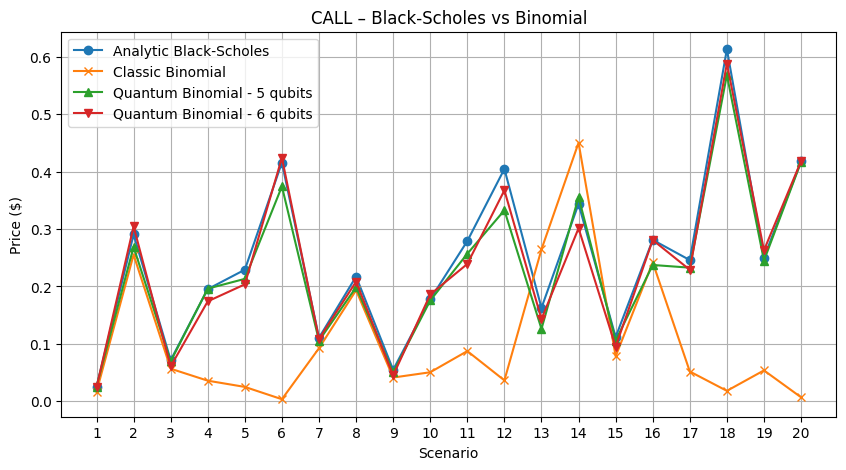

In [ ]:
x = list(range(1, len(scenarios) + 1))

plt.figure(figsize=(10, 5))
plt.plot(x, call_bs_list, marker='o', label="Analytic Black-Scholes")
plt.plot(x, call_binomial_list, marker='x', label="Classic Binomial")
plt.plot(x, call_quantum_binomial_list_5qubits, marker='^', label="Quantum Binomial - 5 qubits")
plt.plot(x, call_quantum_binomial_list_6qubits, marker='v', label="Quantum Binomial - 6 qubits")

plt.xlabel("Scenario")
plt.ylabel("Price ($)")
plt.title("CALL – Black-Scholes vs Binomial")
plt.legend()
plt.grid(True)

plt.xticks(x)

plt.show()

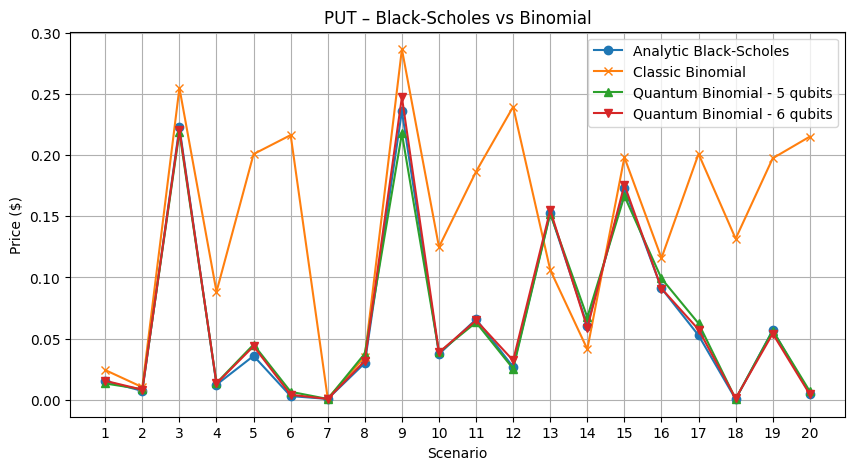

In [ ]:
x = list(range(1, len(scenarios) + 1))

plt.figure(figsize=(10, 5))
plt.plot(x, put_bs_list, marker='o', label="Analytic Black-Scholes")
plt.plot(x, put_binomial_list, marker='x', label="Classic Binomial")
plt.plot(x, put_quantum_binomial_list_5qubits, marker='^', label="Quantum Binomial - 5 qubits")
plt.plot(x, put_quantum_binomial_list_6qubits, marker='v', label="Quantum Binomial - 6 qubits")

plt.xlabel("Scenario")
plt.ylabel("Price ($)")
plt.title("PUT – Black-Scholes vs Binomial")
plt.legend()
plt.grid(True)

plt.xticks(x)

plt.show()